In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import boto3
from io import StringIO 

In [2]:
session = boto3.Session(
         aws_access_key_id='', 
         aws_secret_access_key='')
client = boto3.client('s3', aws_access_key_id='',
        aws_secret_access_key='')

In [3]:
s3 = session.resource('s3')

In [4]:
my_bucket = s3.Bucket('biolog-db')

In [5]:
directory_key = 0
files_key = 0

directories = []
all_files = []
metadata_availability = {}

for my_bucket_object in my_bucket.objects.all():
    all_files.append(my_bucket_object.key)
    temp_name = ''
    for char in my_bucket_object.key:
        if(char=='/'):
            break
        temp_name = temp_name+char
    directories.append(temp_name)

    
directories = list(set(directories))

for item in directories:
    for my_bucket_object in my_bucket.objects.all():
        if(item in my_bucket_object.key and ('metadata' in my_bucket_object.key or 'meta data' in my_bucket_object.key)):
            metadata_availability[item] = 'yes'
            break
        else:
            metadata_availability[item] = 'no'
    


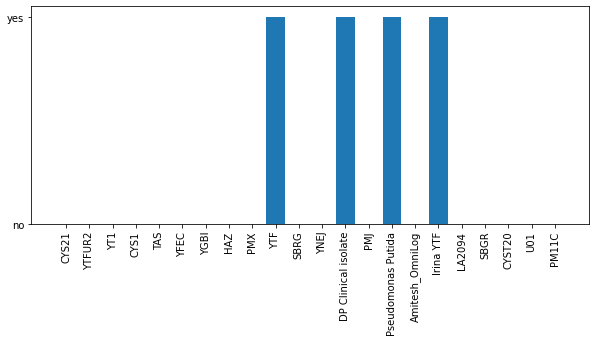

In [6]:
plt.figure(figsize=(10,4))
plt.bar(directories,list(metadata_availability.values()))
plt.xticks(rotation=90);

In [7]:
unique_plate_types = []
unique_dates = []


for my_bucket_object in my_bucket.objects.all():
    if('csv' in my_bucket_object.key ):
        object_key = my_bucket_object.key
        csv_obj = client.get_object(Bucket='biolog-db', Key=object_key)
        body = csv_obj['Body']
        csv_string = body.read().decode('utf-8')
        df = pd.read_csv(StringIO(csv_string))
        curr_plates = df['Plate Type'].unique().tolist()
        temp_curr_dates = df['Setup Time'].unique().tolist()
        
        for plate in curr_plates:
            unique_plate_types.append(curr_plates[0])
            
        for date in temp_curr_dates:
            unique_dates.append(date.split()[0])
            
            
        
        

In [8]:
unique_plate_types = list(set(unique_plate_types))
unique_dates = list(set(unique_dates))
plate_vals = np.zeros([len(unique_plate_types),1])
plates_dict = {}
dates_dict = {}
date_vals = np.zeros([len(unique_dates),1])

In [9]:
for i in range(0,len(unique_plate_types)):
    plates_dict[unique_plate_types[i]] = float(plate_vals[i])
    
for i in range(0,len(unique_dates)):
    dates_dict[unique_dates[i]] = float(date_vals[i])
    


In [11]:
for my_bucket_object in my_bucket.objects.all():
    if('csv' in my_bucket_object.key ):
        object_key = my_bucket_object.key
        csv_obj = client.get_object(Bucket='biolog-db', Key=object_key)
        body = csv_obj['Body']
        csv_string = body.read().decode('utf-8')
        df = pd.read_csv(StringIO(csv_string))
        curr_plates = df['Plate Type'].unique().tolist()
        temp_curr_dates = df['Setup Time'].unique().tolist()
        
        for plate in curr_plates:
            plates_dict[plate] = plates_dict[plate]+1 
            
        for date in temp_curr_dates:
            temp_date = date.split()[0]
            dates_dict[temp_date] = dates_dict[temp_date]+1

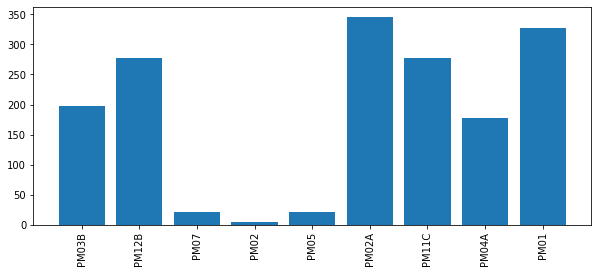

In [12]:
plt.figure(figsize=(10,4))
plt.bar(list(plates_dict.keys()),list(plates_dict.values()))
plt.xticks(rotation=90);

In [13]:
import datetime
dates = [datetime.datetime.strptime(ts, "%m/%d/%Y") for ts in list(dates_dict.keys())]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%m/%d/%Y") for ts in dates]
for i in range(0,len(sorteddates)):
    if(sorteddates[i][3]=='0'):
        temp_date = sorteddates[i][0:3] + sorteddates[i][4:]
        sorteddates[i] = temp_date
    if(sorteddates[i][0]=='0'):
        temp_date = sorteddates[i][1:]
        sorteddates[i] = temp_date
    
            
        

In [14]:
ordered_dates = {}
for i in sorteddates:
    ordered_dates[i] = dates_dict[i]

runs_by_date = pd.DataFrame(list(ordered_dates.values()),columns=['Runs'],index=list(ordered_dates.keys()))
runs_by_date = runs_by_date.cumsum()

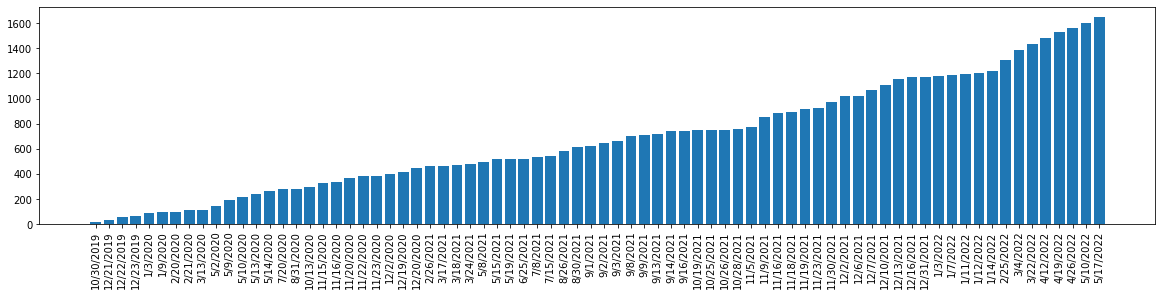

In [15]:
plt.figure(figsize=(20,4))
plt.bar(runs_by_date.index,runs_by_date['Runs'])
plt.xticks(rotation=90);

In [16]:
strains = {'coli':0, 'pyogenes':0,'putida':0,'gas':0,'aureus':0}
for strain in strains:
    for my_bucket_object in my_bucket.objects.all(): 
        if('csv' in my_bucket_object.key and strain in my_bucket_object.key):
            strains[strain] = strains[strain]+1

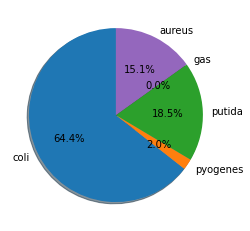

In [17]:
plt.pie(list(strains.values()),labels=list(strains.keys()), autopct='%1.1f%%',
        shadow=True, startangle=90);

In [ ]:
# for my_bucket_object in my_bucket.objects.all():
#     if('csv' in my_bucket_object.key):
#         object_key = my_bucket_object.key
#         csv_obj = client.get_object(Bucket='biolog-db', Key=object_key)
#         body = csv_obj['Body']
#         csv_string = body.read().decode('utf-8')
#         df = pd.read_csv(StringIO(csv_string))

In [21]:
list(plates_dict.keys())

['PM03B', 'PM12B', 'PM07', 'PM02', 'PM05', 'PM02A', 'PM11C', 'PM04A', 'PM01']

In [23]:
metadata_availability

{'CYS21': 'no',
 'YTFUR2': 'no',
 'YT1': 'no',
 'CYS1': 'no',
 'TAS': 'no',
 'YFEC': 'no',
 'YGBI': 'no',
 'HAZ': 'no',
 'PMX': 'no',
 'YTF': 'yes',
 'SBRG': 'no',
 'YNEJ': 'no',
 'DP Clinical isolate': 'yes',
 'PMJ': 'no',
 'Pseudomonas Putida': 'yes',
 'Amitesh_OmniLog': 'no',
 'Irina YTF': 'yes',
 'LA2094': 'no',
 'SBGR': 'no',
 'CYST20': 'no',
 'U01': 'no',
 'PM11C': 'no'}

In [29]:
files_with_metadata = []
for key in metadata_availability.keys():
    if(metadata_availability[key]=='yes'):
        files_with_metadata.append(key)

In [49]:
metadata_plates_dict = {} 
secondary_plates_dict = {}
keys = list(plates_dict.keys())

for i in keys:
    metadata_plates_dict[i] = 0
    secondary_plates_dict[i] = 0
    
for file in files_with_metadata[1:]:
    for my_bucket_object in my_bucket.objects.all(): 
            if('csv' in my_bucket_object.key and file in my_bucket_object.key):
                object_key = my_bucket_object.key
                csv_obj = client.get_object(Bucket='biolog-db', Key=object_key)
                body = csv_obj['Body']
                csv_string = body.read().decode('utf-8')
                df = pd.read_csv(StringIO(csv_string))
                curr_plates = df['Plate Type'].unique().tolist()
                
                for pl in curr_plates:
                    metadata_plates_dict[pl] = metadata_plates_dict[pl]+1
                    
metadata_plates_dict

{'PM03B': 124,
 'PM12B': 0,
 'PM07': 21,
 'PM02': 0,
 'PM05': 21,
 'PM02A': 138,
 'PM11C': 0,
 'PM04A': 104,
 'PM01': 96}

In [44]:
for my_bucket_object in my_bucket.objects.all(): 
        if('csv' in my_bucket_object.key):
            object_key = my_bucket_object.key
            csv_obj = client.get_object(Bucket='biolog-db', Key=object_key)
            body = csv_obj['Body']
            csv_string = body.read().decode('utf-8')
            df = pd.read_csv(StringIO(csv_string))
            curr_plates = df['Plate Type'].unique().tolist()

            for pl in curr_plates:
                secondary_plates_dict[pl] = secondary_plates_dict[pl]+1

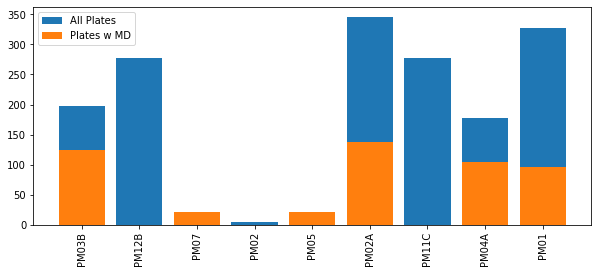

In [51]:
plt.figure(figsize=(10,4))
plt.bar(list(plates_dict.keys()),list(plates_dict.values()))
plt.xticks(rotation=90);
plt.bar(list(metadata_plates_dict.keys()),list(metadata_plates_dict.values()))
plt.xticks(rotation=90);
plt.legend(['All Plates','Plates w MD'])